In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_t1_mask_t1_native_k5_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 198)
(631390, 1)
validation
(74368, 198)
(74368, 1)
test
(85358, 198)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 892929 (3.41 MB)


Trainable params: 892929 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:29 - loss: 0.0632 - STD: 1.1276e-04 - MAE: 0.2346

 6/64 [=>............................] - ETA: 0s - loss: 0.0255 - STD: 9.4872e-05 - MAE: 0.1245  

11/64 [====>.........................] - ETA: 0s - loss: 0.0240 - STD: 6.5321e-05 - MAE: 0.1200

16/64 [======>.......................] - ETA: 0s - loss: 0.0204 - STD: 5.6137e-05 - MAE: 0.1082

21/64 [========>.....................] - ETA: 0s - loss: 0.0185 - STD: 5.3431e-05 - MAE: 0.1051

26/64 [===========>..................] - ETA: 0s - loss: 0.0170 - STD: 5.2776e-05 - MAE: 0.1008

31/64 [=============>................] - ETA: 0s - loss: 0.0160 - STD: 5.2700e-05 - MAE: 0.0968

36/64 [===============>..............] - ETA: 0s - loss: 0.0152 - STD: 5.3638e-05 - MAE: 0.0939

41/64 [==================>...........] - ETA: 0s - loss: 0.0145 - STD: 5.5721e-05 - MAE: 0.0922

46/64 [====================>.........] - ETA: 0s - loss: 0.0141 - STD: 5.8209e-05 - MAE: 0.0910

51/64 [======================>.......] - ETA: 0s - loss: 0.0137 - STD: 6.0697e-05 - MAE: 0.0896

56/64 [=========================>....] - ETA: 0s - loss: 0.0133 - STD: 6.3592e-05 - MAE: 0.0885

61/64 [===========================>..] - ETA: 0s - loss: 0.0131 - STD: 6.7124e-05 - MAE: 0.0877

62/64 [============================>.] - ETA: 0s - loss: 0.0130 - STD: 6.7821e-05 - MAE: 0.0876

64/64 [==============================] - 3s 32ms/step - loss: 0.0129 - STD: 6.9322e-05 - MAE: 0.0873 - val_loss: 0.0094 - val_STD: 9.3251e-05 - val_MAE: 0.0769


Epoch 2/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0098 - STD: 1.2008e-04 - MAE: 0.0779

 6/64 [=>............................] - ETA: 0s - loss: 0.0098 - STD: 1.2458e-04 - MAE: 0.0775

11/64 [====>.........................] - ETA: 0s - loss: 0.0099 - STD: 1.3113e-04 - MAE: 0.0776

16/64 [======>.......................] - ETA: 0s - loss: 0.0099 - STD: 1.3849e-04 - MAE: 0.0777

21/64 [========>.....................] - ETA: 0s - loss: 0.0099 - STD: 1.4605e-04 - MAE: 0.0779

26/64 [===========>..................] - ETA: 0s - loss: 0.0099 - STD: 1.5374e-04 - MAE: 0.0779

31/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 1.6200e-04 - MAE: 0.0779

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 1.7088e-04 - MAE: 0.0779

41/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 1.8036e-04 - MAE: 0.0779

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 1.9038e-04 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.0137e-04 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.1292e-04 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.2558e-04 - MAE: 0.0778

64/64 [==============================] - 1s 13ms/step - loss: 0.0099 - STD: 2.3366e-04 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 3.2646e-04 - val_MAE: 0.0764


Epoch 3/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0101 - STD: 4.2236e-04 - MAE: 0.0789

 6/64 [=>............................] - ETA: 0s - loss: 0.0098 - STD: 4.4186e-04 - MAE: 0.0780

11/64 [====>.........................] - ETA: 0s - loss: 0.0099 - STD: 4.6556e-04 - MAE: 0.0778

16/64 [======>.......................] - ETA: 0s - loss: 0.0099 - STD: 4.9444e-04 - MAE: 0.0779

21/64 [========>.....................] - ETA: 0s - loss: 0.0099 - STD: 5.2454e-04 - MAE: 0.0778

26/64 [===========>..................] - ETA: 0s - loss: 0.0099 - STD: 5.5974e-04 - MAE: 0.0778

31/64 [=============>................] - ETA: 0s - loss: 0.0099 - STD: 5.9758e-04 - MAE: 0.0777

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 6.4024e-04 - MAE: 0.0777

41/64 [==================>...........] - ETA: 0s - loss: 0.0098 - STD: 6.8971e-04 - MAE: 0.0778

46/64 [====================>.........] - ETA: 0s - loss: 0.0098 - STD: 7.4557e-04 - MAE: 0.0778

51/64 [======================>.......] - ETA: 0s - loss: 0.0098 - STD: 8.0935e-04 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0098 - STD: 8.8516e-04 - MAE: 0.0778

61/64 [===========================>..] - ETA: 0s - loss: 0.0098 - STD: 9.7413e-04 - MAE: 0.0778

64/64 [==============================] - 1s 13ms/step - loss: 0.0098 - STD: 0.0010 - MAE: 0.0777 - val_loss: 0.0092 - val_STD: 0.0019 - val_MAE: 0.0757


Epoch 4/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0099 - STD: 0.0024 - MAE: 0.0775

 6/64 [=>............................] - ETA: 0s - loss: 0.0098 - STD: 0.0027 - MAE: 0.0773

11/64 [====>.........................] - ETA: 0s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0773

16/64 [======>.......................] - ETA: 0s - loss: 0.0097 - STD: 0.0034 - MAE: 0.0772

21/64 [========>.....................] - ETA: 0s - loss: 0.0097 - STD: 0.0038 - MAE: 0.0772

26/64 [===========>..................] - ETA: 0s - loss: 0.0096 - STD: 0.0044 - MAE: 0.0770

31/64 [=============>................] - ETA: 0s - loss: 0.0096 - STD: 0.0051 - MAE: 0.0769

36/64 [===============>..............] - ETA: 0s - loss: 0.0095 - STD: 0.0059 - MAE: 0.0768

40/64 [=================>............] - ETA: 0s - loss: 0.0095 - STD: 0.0067 - MAE: 0.0767

45/64 [====================>.........] - ETA: 0s - loss: 0.0094 - STD: 0.0078 - MAE: 0.0764

51/64 [======================>.......] - ETA: 0s - loss: 0.0093 - STD: 0.0094 - MAE: 0.0760

56/64 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.0109 - MAE: 0.0758

61/64 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 0.0124 - MAE: 0.0755

64/64 [==============================] - 1s 13ms/step - loss: 0.0091 - STD: 0.0134 - MAE: 0.0753 - val_loss: 0.0077 - val_STD: 0.0264 - val_MAE: 0.0688


Epoch 5/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0082 - STD: 0.0337 - MAE: 0.0711

 6/64 [=>............................] - ETA: 0s - loss: 0.0082 - STD: 0.0346 - MAE: 0.0711

11/64 [====>.........................] - ETA: 0s - loss: 0.0081 - STD: 0.0353 - MAE: 0.0708

16/64 [======>.......................] - ETA: 0s - loss: 0.0081 - STD: 0.0359 - MAE: 0.0704

21/64 [========>.....................] - ETA: 0s - loss: 0.0081 - STD: 0.0365 - MAE: 0.0703

26/64 [===========>..................] - ETA: 0s - loss: 0.0080 - STD: 0.0371 - MAE: 0.0701

31/64 [=============>................] - ETA: 0s - loss: 0.0080 - STD: 0.0377 - MAE: 0.0699

36/64 [===============>..............] - ETA: 0s - loss: 0.0080 - STD: 0.0383 - MAE: 0.0695

41/64 [==================>...........] - ETA: 0s - loss: 0.0079 - STD: 0.0388 - MAE: 0.0692

46/64 [====================>.........] - ETA: 0s - loss: 0.0079 - STD: 0.0393 - MAE: 0.0689

51/64 [======================>.......] - ETA: 0s - loss: 0.0078 - STD: 0.0399 - MAE: 0.0686

56/64 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0405 - MAE: 0.0683

61/64 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.0412 - MAE: 0.0680

64/64 [==============================] - 1s 13ms/step - loss: 0.0077 - STD: 0.0416 - MAE: 0.0678 - val_loss: 0.0067 - val_STD: 0.0387 - val_MAE: 0.0619


Epoch 6/10000


 1/64 [..............................] - ETA: 0s - loss: 0.0069 - STD: 0.0498 - MAE: 0.0631

 6/64 [=>............................] - ETA: 0s - loss: 0.0071 - STD: 0.0510 - MAE: 0.0639

11/64 [====>.........................] - ETA: 0s - loss: 0.0070 - STD: 0.0513 - MAE: 0.0636

16/64 [======>.......................] - ETA: 0s - loss: 0.0070 - STD: 0.0519 - MAE: 0.0633

21/64 [========>.....................] - ETA: 0s - loss: 0.0069 - STD: 0.0521 - MAE: 0.0631

26/64 [===========>..................] - ETA: 0s - loss: 0.0069 - STD: 0.0524 - MAE: 0.0629

31/64 [=============>................] - ETA: 0s - loss: 0.0068 - STD: 0.0526 - MAE: 0.0627

36/64 [===============>..............] - ETA: 0s - loss: 0.0068 - STD: 0.0527 - MAE: 0.0625

41/64 [==================>...........] - ETA: 0s - loss: 0.0068 - STD: 0.0529 - MAE: 0.0625

46/64 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0530 - MAE: 0.0623

51/64 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0533 - MAE: 0.0623

56/64 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0535 - MAE: 0.0622

61/64 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0537 - MAE: 0.0621

64/64 [==============================] - 1s 13ms/step - loss: 0.0067 - STD: 0.0538 - MAE: 0.0620 - val_loss: 0.0060 - val_STD: 0.0430 - val_MAE: 0.0597


Epoch 7/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0067 - STD: 0.0581 - MAE: 0.0627

 6/64 [=>............................] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0607

11/64 [====>.........................] - ETA: 0s - loss: 0.0066 - STD: 0.0567 - MAE: 0.0610

16/64 [======>.......................] - ETA: 0s - loss: 0.0065 - STD: 0.0570 - MAE: 0.0608

21/64 [========>.....................] - ETA: 0s - loss: 0.0065 - STD: 0.0570 - MAE: 0.0607

26/64 [===========>..................] - ETA: 0s - loss: 0.0065 - STD: 0.0572 - MAE: 0.0608

31/64 [=============>................] - ETA: 0s - loss: 0.0065 - STD: 0.0572 - MAE: 0.0606

36/64 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0572 - MAE: 0.0606

41/64 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0572 - MAE: 0.0606

46/64 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0573 - MAE: 0.0605

51/64 [======================>.......] - ETA: 0s - loss: 0.0065 - STD: 0.0573 - MAE: 0.0605

56/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0574 - MAE: 0.0604

61/64 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0575 - MAE: 0.0603

64/64 [==============================] - 1s 13ms/step - loss: 0.0064 - STD: 0.0576 - MAE: 0.0603 - val_loss: 0.0058 - val_STD: 0.0441 - val_MAE: 0.0572


Epoch 8/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0591 - MAE: 0.0593

 6/64 [=>............................] - ETA: 0s - loss: 0.0064 - STD: 0.0593 - MAE: 0.0598

11/64 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0594

16/64 [======>.......................] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0594

21/64 [========>.....................] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0595

26/64 [===========>..................] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0595

31/64 [=============>................] - ETA: 0s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0594

36/64 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0594

41/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0595

46/64 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0597

51/64 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0596

56/64 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0596

61/64 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0596

64/64 [==============================] - 1s 13ms/step - loss: 0.0063 - STD: 0.0590 - MAE: 0.0595 - val_loss: 0.0058 - val_STD: 0.0452 - val_MAE: 0.0567


Epoch 9/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0586 - MAE: 0.0583

 6/64 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0593 - MAE: 0.0591

11/64 [====>.........................] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0592

16/64 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0591

21/64 [========>.....................] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0592

26/64 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0590

31/64 [=============>................] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0589

36/64 [===============>..............] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0589

41/64 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0589

46/64 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0588

51/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0602 - MAE: 0.0588

56/64 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0603 - MAE: 0.0588

61/64 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0588

64/64 [==============================] - 1s 13ms/step - loss: 0.0062 - STD: 0.0604 - MAE: 0.0588 - val_loss: 0.0056 - val_STD: 0.0477 - val_MAE: 0.0570


Epoch 10/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0061 - STD: 0.0619 - MAE: 0.0592

 6/64 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0582

11/64 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0586

16/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0586

21/64 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0586

26/64 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0603 - MAE: 0.0585

31/64 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0584

36/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0584

42/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0584

47/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0584

52/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0583

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0583

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0583

64/64 [==============================] - 1s 13ms/step - loss: 0.0061 - STD: 0.0610 - MAE: 0.0583 - val_loss: 0.0057 - val_STD: 0.0474 - val_MAE: 0.0558


Epoch 11/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0611 - MAE: 0.0570

 6/64 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0578

11/64 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0580

16/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0619 - MAE: 0.0582

21/64 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0618 - MAE: 0.0581

26/64 [===========>..................] - ETA: 0s - loss: 0.0061 - STD: 0.0617 - MAE: 0.0582

31/64 [=============>................] - ETA: 0s - loss: 0.0061 - STD: 0.0617 - MAE: 0.0584

36/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0613 - MAE: 0.0585

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0586

46/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0585

51/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0585

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0585

61/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0584

64/64 [==============================] - 1s 13ms/step - loss: 0.0061 - STD: 0.0609 - MAE: 0.0584 - val_loss: 0.0055 - val_STD: 0.0496 - val_MAE: 0.0562


Epoch 12/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0580

 6/64 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0625 - MAE: 0.0577

11/64 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0577

16/64 [======>.......................] - ETA: 0s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0577

21/64 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0628 - MAE: 0.0576

26/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0576

31/64 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0627 - MAE: 0.0576

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0575

41/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0575

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0575

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0575

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0575

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0575

64/64 [==============================] - 1s 13ms/step - loss: 0.0060 - STD: 0.0626 - MAE: 0.0576 - val_loss: 0.0058 - val_STD: 0.0470 - val_MAE: 0.0555


Epoch 13/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0594 - MAE: 0.0563

 6/64 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0616 - MAE: 0.0589

11/64 [====>.........................] - ETA: 0s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0583

16/64 [======>.......................] - ETA: 0s - loss: 0.0061 - STD: 0.0611 - MAE: 0.0583

21/64 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0581

26/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0580

31/64 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0580

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0579

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0578

46/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0577

51/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

56/64 [=========================>....] - ETA: 0s - loss: 0.0060 - STD: 0.0619 - MAE: 0.0576

61/64 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576

64/64 [==============================] - 1s 13ms/step - loss: 0.0060 - STD: 0.0620 - MAE: 0.0576 - val_loss: 0.0056 - val_STD: 0.0487 - val_MAE: 0.0551


Epoch 14/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0060 - STD: 0.0611 - MAE: 0.0571

 6/64 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0572

11/64 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0570

16/64 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0571

21/64 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0571

26/64 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0571

31/64 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0571

36/64 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0571

41/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0571

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0572

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0571

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0633 - MAE: 0.0572

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0571

64/64 [==============================] - 1s 13ms/step - loss: 0.0059 - STD: 0.0632 - MAE: 0.0571 - val_loss: 0.0054 - val_STD: 0.0511 - val_MAE: 0.0553


Epoch 15/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0572

 6/64 [=>............................] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0575

11/64 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0576

16/64 [======>.......................] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0574

21/64 [========>.....................] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0575

26/64 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0574

31/64 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0574

36/64 [===============>..............] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

41/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0573

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0573

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0630 - MAE: 0.0573

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572

64/64 [==============================] - 1s 13ms/step - loss: 0.0059 - STD: 0.0629 - MAE: 0.0572 - val_loss: 0.0055 - val_STD: 0.0535 - val_MAE: 0.0578


Epoch 16/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0062 - STD: 0.0658 - MAE: 0.0605

 5/64 [=>............................] - ETA: 0s - loss: 0.0061 - STD: 0.0620 - MAE: 0.0581

 9/64 [===>..........................] - ETA: 0s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0578

14/64 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0576

19/64 [=======>......................] - ETA: 0s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0574

24/64 [==========>...................] - ETA: 0s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0573

29/64 [============>.................] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0572

34/64 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0572

39/64 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0571

44/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0571

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0571

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0571

59/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0570

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0570

64/64 [==============================] - 1s 13ms/step - loss: 0.0059 - STD: 0.0629 - MAE: 0.0570 - val_loss: 0.0054 - val_STD: 0.0519 - val_MAE: 0.0550


Epoch 17/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0634 - MAE: 0.0561

 6/64 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0566

11/64 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0567

16/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0568

21/64 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0568

26/64 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0568

31/64 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0568

36/64 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0568

42/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0569

47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0569

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0634 - MAE: 0.0569

57/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0570

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0570

64/64 [==============================] - 1s 13ms/step - loss: 0.0058 - STD: 0.0633 - MAE: 0.0570 - val_loss: 0.0053 - val_STD: 0.0522 - val_MAE: 0.0549


Epoch 18/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0565

 6/64 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0563

11/64 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0639 - MAE: 0.0565

16/64 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0564

21/64 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0565

26/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0564

31/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0564

36/64 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0564

41/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

46/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0564

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0565

64/64 [==============================] - 1s 13ms/step - loss: 0.0058 - STD: 0.0642 - MAE: 0.0565 - val_loss: 0.0053 - val_STD: 0.0547 - val_MAE: 0.0556


Epoch 19/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0672 - MAE: 0.0574

 6/64 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0646 - MAE: 0.0567

11/64 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0645 - MAE: 0.0570

16/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0646 - MAE: 0.0568

21/64 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0565

26/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0565

31/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0565

36/64 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0565

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0566

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0566

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0566

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0566

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0566

64/64 [==============================] - 1s 13ms/step - loss: 0.0058 - STD: 0.0642 - MAE: 0.0566 - val_loss: 0.0055 - val_STD: 0.0514 - val_MAE: 0.0546


Epoch 20/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0626 - MAE: 0.0553

 6/64 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0559

11/64 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0561

16/64 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0562

21/64 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

26/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

31/64 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0564

36/64 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0565

41/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0566

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

64/64 [==============================] - 1s 13ms/step - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565 - val_loss: 0.0053 - val_STD: 0.0546 - val_MAE: 0.0554


Epoch 21/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0652 - MAE: 0.0567

 6/64 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

11/64 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0563

16/64 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0562

21/64 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

26/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0564

31/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0564

36/64 [===============>..............] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0564

41/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

46/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0564

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563

64/64 [==============================] - 1s 13ms/step - loss: 0.0057 - STD: 0.0643 - MAE: 0.0563 - val_loss: 0.0053 - val_STD: 0.0543 - val_MAE: 0.0548


Epoch 22/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0559

 7/64 [==>...........................] - ETA: 0s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0564

12/64 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0567

17/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

22/64 [=========>....................] - ETA: 0s - loss: 0.0058 - STD: 0.0636 - MAE: 0.0567

27/64 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0567

32/64 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0567

37/64 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0566

42/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0638 - MAE: 0.0565

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0565

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

64/64 [==============================] - 1s 13ms/step - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564 - val_loss: 0.0053 - val_STD: 0.0553 - val_MAE: 0.0552


Epoch 23/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0659 - MAE: 0.0571

 6/64 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0563

12/64 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0647 - MAE: 0.0567

17/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0644 - MAE: 0.0566

22/64 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

27/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0564

32/64 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0563

37/64 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0563

42/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

52/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0562

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0563

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0563

64/64 [==============================] - 1s 13ms/step - loss: 0.0057 - STD: 0.0644 - MAE: 0.0564 - val_loss: 0.0053 - val_STD: 0.0530 - val_MAE: 0.0546


Epoch 24/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0630 - MAE: 0.0554

 6/64 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0622 - MAE: 0.0588

11/64 [====>.........................] - ETA: 0s - loss: 0.0063 - STD: 0.0609 - MAE: 0.0592

16/64 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0587

21/64 [========>.....................] - ETA: 0s - loss: 0.0061 - STD: 0.0595 - MAE: 0.0582

26/64 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0601 - MAE: 0.0580

31/64 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0607 - MAE: 0.0578

36/64 [===============>..............] - ETA: 0s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0576

41/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0574

46/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0572

51/64 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0571

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0571

61/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0570

64/64 [==============================] - 1s 13ms/step - loss: 0.0059 - STD: 0.0626 - MAE: 0.0570 - val_loss: 0.0053 - val_STD: 0.0538 - val_MAE: 0.0546


Epoch 25/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0566

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0637 - MAE: 0.0558

11/64 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0561

16/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0559

21/64 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0558

26/64 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0559

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0558

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0559

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0559

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0559

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0560

57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0560

62/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0560

64/64 [==============================] - 1s 13ms/step - loss: 0.0057 - STD: 0.0649 - MAE: 0.0560 - val_loss: 0.0052 - val_STD: 0.0557 - val_MAE: 0.0550


Epoch 26/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0559

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0556

11/64 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0558

16/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0559

21/64 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558

26/64 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0558

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0558

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0559

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0559

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0559

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0559

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0559

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0559

64/64 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0652 - MAE: 0.0560 - val_loss: 0.0058 - val_STD: 0.0507 - val_MAE: 0.0557


Epoch 27/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0064 - STD: 0.0596 - MAE: 0.0573

 6/64 [=>............................] - ETA: 0s - loss: 0.0059 - STD: 0.0646 - MAE: 0.0574

11/64 [====>.........................] - ETA: 0s - loss: 0.0059 - STD: 0.0631 - MAE: 0.0571

16/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0632 - MAE: 0.0569

21/64 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0631 - MAE: 0.0567

26/64 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0566

31/64 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0637 - MAE: 0.0565

36/64 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

41/64 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0640 - MAE: 0.0563

46/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0563

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0562

56/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0562

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0562

64/64 [==============================] - 1s 13ms/step - loss: 0.0057 - STD: 0.0645 - MAE: 0.0562 - val_loss: 0.0053 - val_STD: 0.0553 - val_MAE: 0.0547


Epoch 28/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0552

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0557

11/64 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0558

16/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0558

21/64 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0558

26/64 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0558

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0558

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0558

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0558

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0558

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0653 - MAE: 0.0557

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0558

64/64 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0654 - MAE: 0.0558 - val_loss: 0.0055 - val_STD: 0.0527 - val_MAE: 0.0549


Epoch 29/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0056 - STD: 0.0619 - MAE: 0.0545

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0557

11/64 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0559

16/64 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0561

21/64 [========>.....................] - ETA: 0s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0561

26/64 [===========>..................] - ETA: 0s - loss: 0.0057 - STD: 0.0648 - MAE: 0.0560

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0560

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0560

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0559

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0559

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0559

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0559

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0652 - MAE: 0.0558

64/64 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0652 - MAE: 0.0558 - val_loss: 0.0052 - val_STD: 0.0575 - val_MAE: 0.0553


Epoch 30/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0675 - MAE: 0.0567

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0659 - MAE: 0.0557

11/64 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0558

16/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0557

21/64 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0557

26/64 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0558

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0558

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0558

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0558

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0558

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0558

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0558

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0558

64/64 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0654 - MAE: 0.0558 - val_loss: 0.0052 - val_STD: 0.0580 - val_MAE: 0.0565


Epoch 31/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0677 - MAE: 0.0580

 6/64 [=>............................] - ETA: 0s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0564

11/64 [====>.........................] - ETA: 0s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0567

16/64 [======>.......................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0562

21/64 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0560

26/64 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0560

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0559

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0559

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0559

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0649 - MAE: 0.0559

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0559

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558

64/64 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0651 - MAE: 0.0558 - val_loss: 0.0053 - val_STD: 0.0553 - val_MAE: 0.0549


Epoch 32/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0649 - MAE: 0.0552

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0555

11/64 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0555

16/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0556

21/64 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0556

26/64 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0556

31/64 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0555

36/64 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0555

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0555

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0555

51/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0555

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0555

61/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0555

64/64 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0657 - MAE: 0.0555 - val_loss: 0.0052 - val_STD: 0.0587 - val_MAE: 0.0562


Epoch 33/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0691 - MAE: 0.0576

 5/64 [=>............................] - ETA: 0s - loss: 0.0058 - STD: 0.0651 - MAE: 0.0566

10/64 [===>..........................] - ETA: 0s - loss: 0.0058 - STD: 0.0650 - MAE: 0.0569

15/64 [======>.......................] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0566

20/64 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0640 - MAE: 0.0567

25/64 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0639 - MAE: 0.0564

30/64 [=============>................] - ETA: 0s - loss: 0.0057 - STD: 0.0641 - MAE: 0.0562

35/64 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0561

40/64 [=================>............] - ETA: 0s - loss: 0.0057 - STD: 0.0644 - MAE: 0.0561

45/64 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0560

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0560

54/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0646 - MAE: 0.0560

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0647 - MAE: 0.0560

64/64 [==============================] - 1s 13ms/step - loss: 0.0057 - STD: 0.0648 - MAE: 0.0559 - val_loss: 0.0052 - val_STD: 0.0556 - val_MAE: 0.0547


Epoch 34/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0054 - STD: 0.0653 - MAE: 0.0546

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0555

11/64 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0554

17/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0555

22/64 [=========>....................] - ETA: 0s - loss: 0.0056 - STD: 0.0658 - MAE: 0.0556

27/64 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0556

32/64 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0557

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0657 - MAE: 0.0557

42/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556

47/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556

57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556

64/64 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556 - val_loss: 0.0052 - val_STD: 0.0589 - val_MAE: 0.0566


Epoch 35/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0057 - STD: 0.0686 - MAE: 0.0580

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0559

11/64 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0559

16/64 [======>.......................] - ETA: 0s - loss: 0.0056 - STD: 0.0650 - MAE: 0.0557

21/64 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0556

27/64 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0556

32/64 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0556

37/64 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556

42/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0556

47/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0557

57/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0556

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0556

64/64 [==============================] - 1s 13ms/step - loss: 0.0056 - STD: 0.0655 - MAE: 0.0556 - val_loss: 0.0053 - val_STD: 0.0545 - val_MAE: 0.0547


Epoch 36/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0058 - STD: 0.0642 - MAE: 0.0555

 6/64 [=>............................] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0552

11/64 [====>.........................] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0553

16/64 [======>.......................] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0553

21/64 [========>.....................] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0552

26/64 [===========>..................] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0552

31/64 [=============>................] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0552

36/64 [===============>..............] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0552

41/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0552

46/64 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0553

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0553

57/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0553

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0553

64/64 [==============================] - 1s 13ms/step - loss: 0.0055 - STD: 0.0659 - MAE: 0.0553 - val_loss: 0.0053 - val_STD: 0.0551 - val_MAE: 0.0547


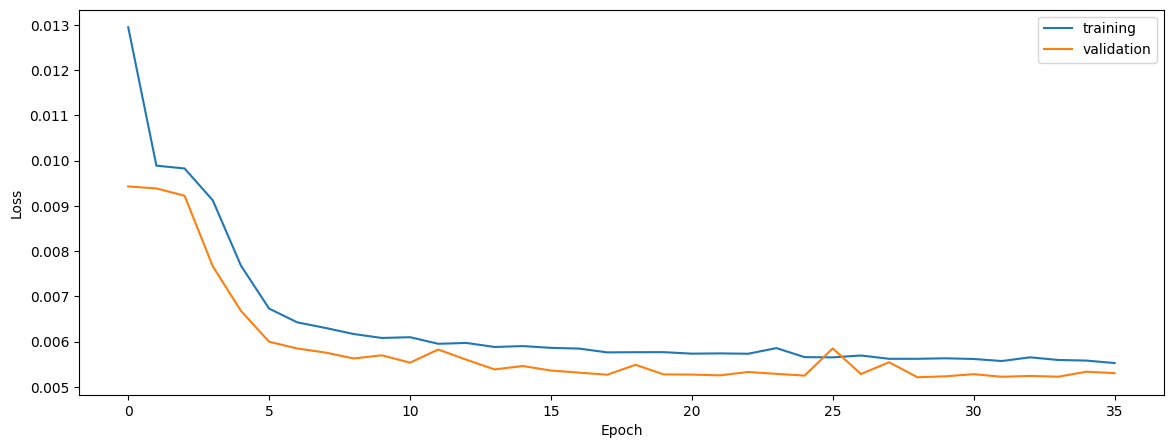

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.6611565671493002
0.6692562829152457
0.6631622645403658


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.6611565671493002
0.6692562829152457
0.6631622645403658


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.6654735842381916
0.671820004542541
0.6777662305914707


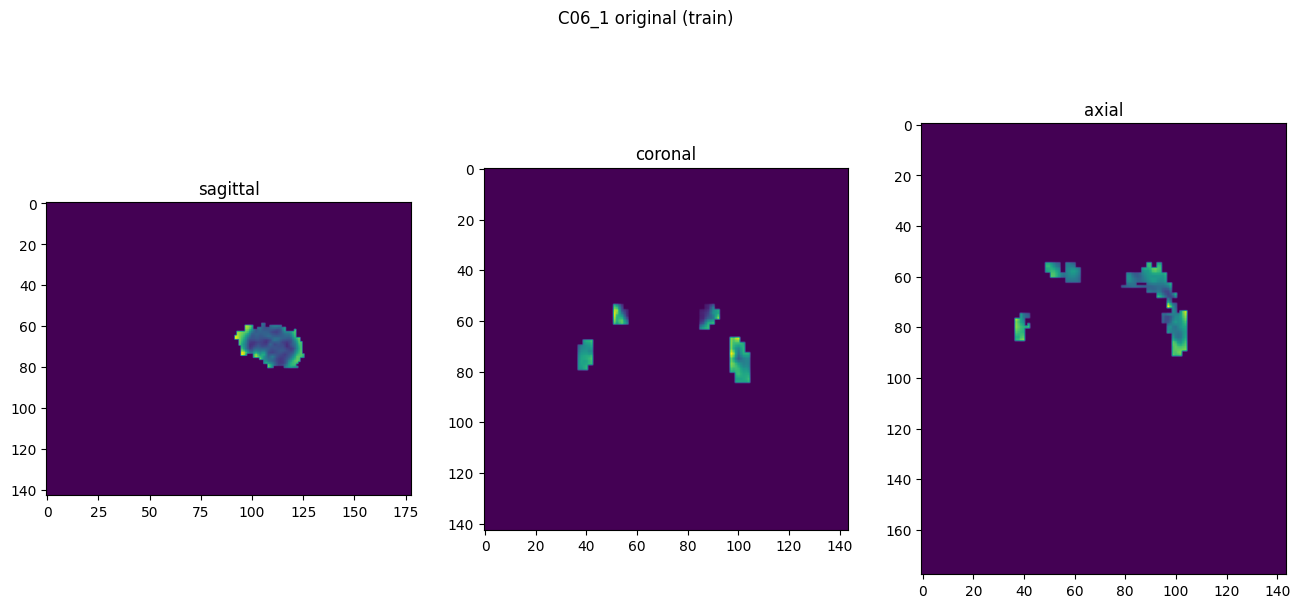

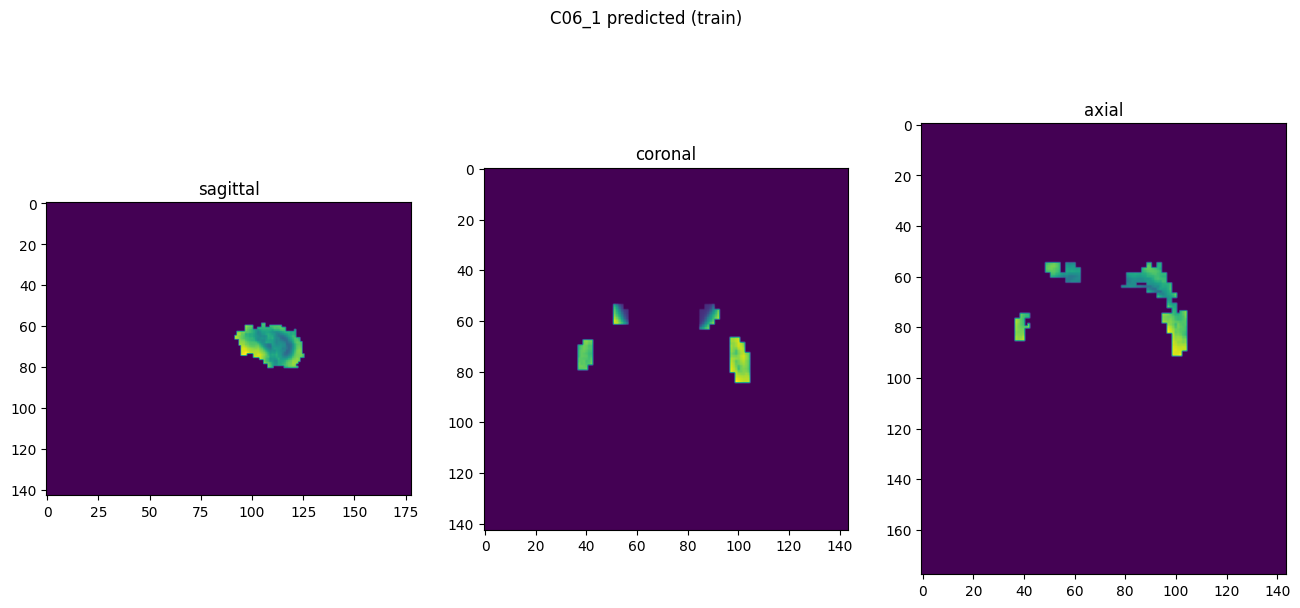

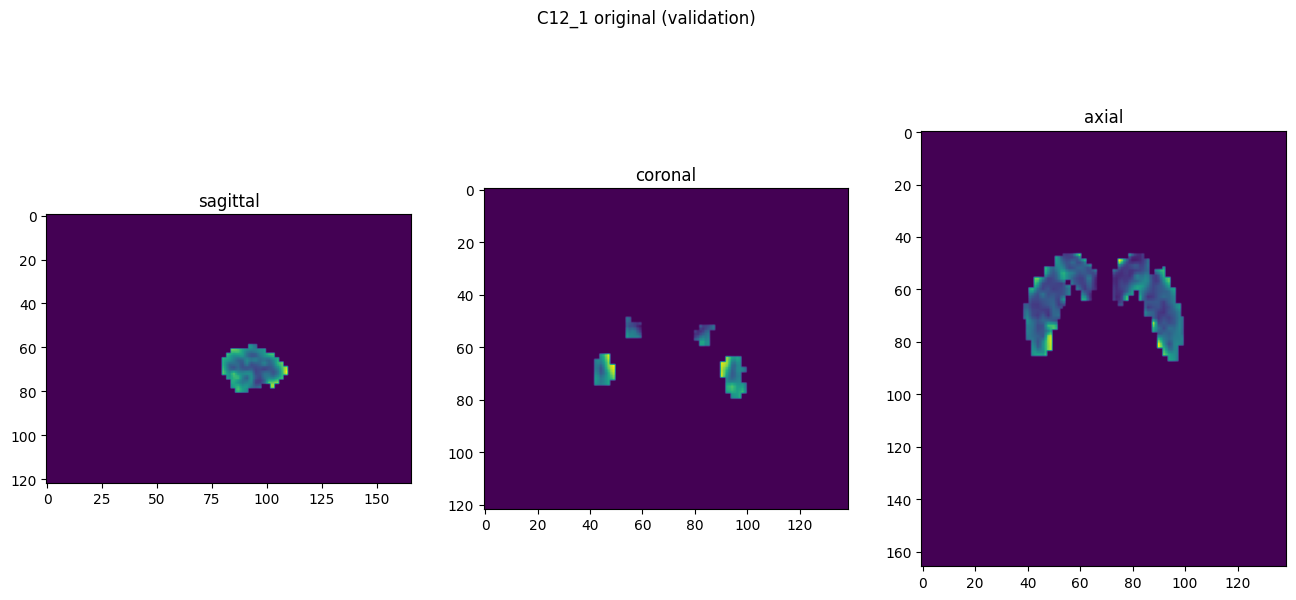

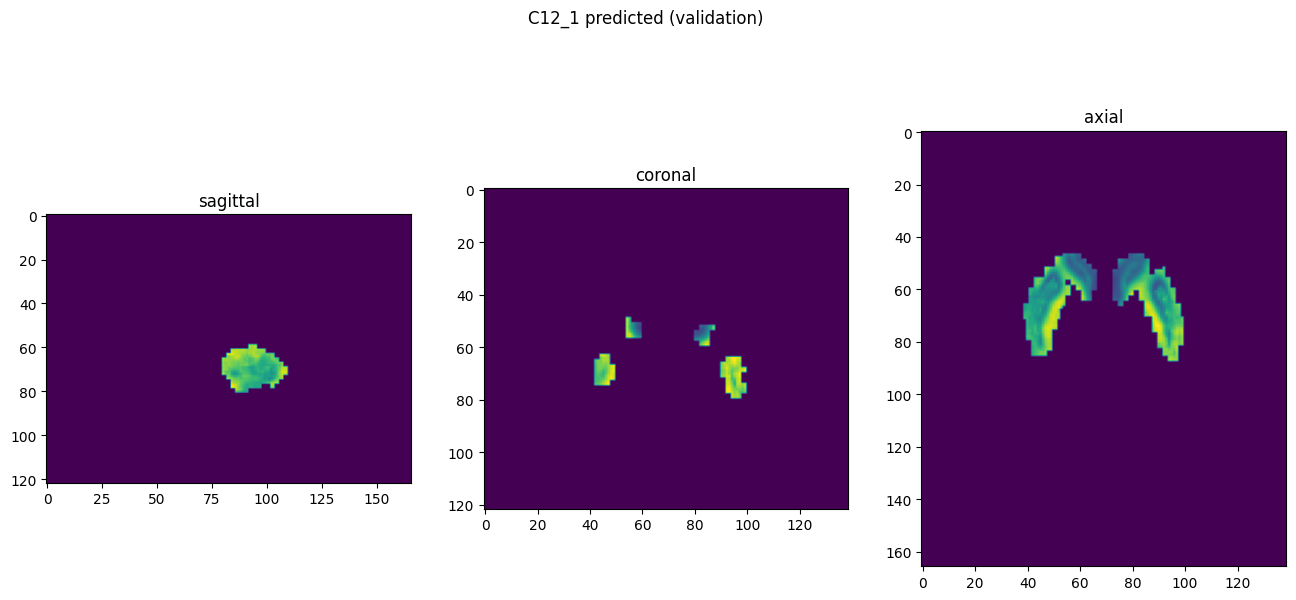

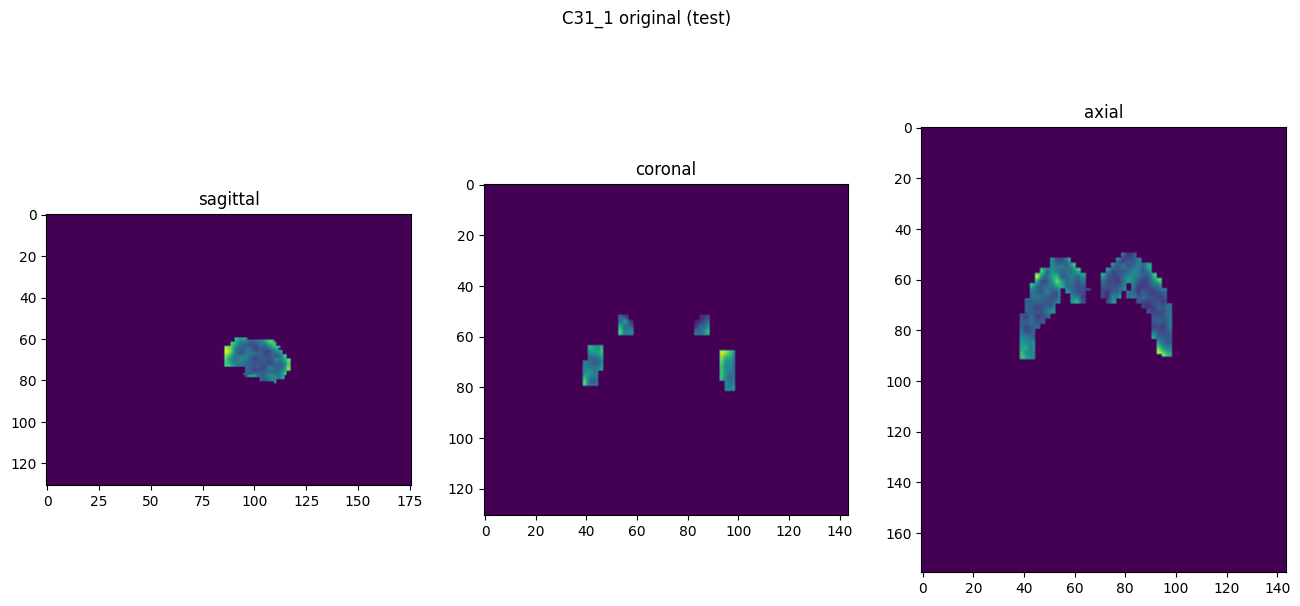

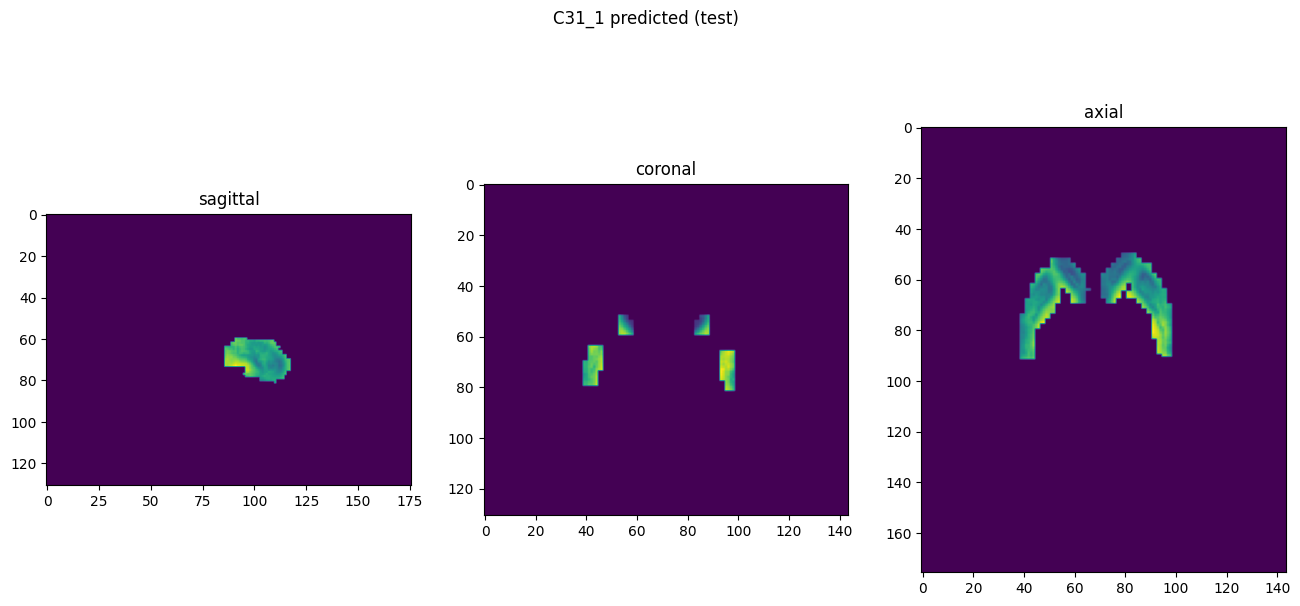

In [10]:
showResults(model, gen, threshold=None, background=False)